In [1]:
#### Load the libraries 

import os
import webbrowser
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option("display.max_rows", None, "display.max_columns", None)

# Data prep

## Oxford Economics data

File downloaded from Oxford Economics on 17th of June 2021
Last data Update date is 30th of April 2021

#### Load the file with GVA and Employment

In [2]:
# overall Greater London file
df = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Greater London GVA and Employment - 17 June 2021 10_48_24.xlsx', 'Default')

# Westminster file
westm = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Westminster GVA and Employment - 30 June 2021 15_29_52.xlsx', 'Default')
del westm['Databank']

In [3]:
df = df.append(westm, ignore_index=True)

#### Look at the data

In [4]:
#df.head()
#westm.head()

In [5]:
#df.dtypes

In [6]:
#list(df)

#### Reshape data

In [7]:
## Reshape 1: Turn years columns into one

df = pd.melt(df, id_vars=('Location',
 'Indicator',
 'Sector',
 'Units',
 'Scale',
 'Measurement',
 'Source',
 'Seasonally adjusted',
 'Base year price',
 'Base year index',
 'Historical end',
 'Date of last update',
 'Source details',
 'Additional source details',
 'Contact email',
 'Location code',
 'Indicator code')
  , var_name="year", value_name="value" )

In [8]:
#df

In [9]:
## Reshape 2: Make sectors as columns
## a lot of columns will have to go so that reshape is efficient
# reset index gets rid of the multilevel structure

df = pd.pivot_table(df, values='value', index=['Location',
 'Indicator',
 'Units',
 'Scale',
 'Measurement',
 'year'],
columns=['Sector']).reset_index()

In [10]:
#df

In [11]:
#list(df)

In [12]:
df["Aggr2"] = df['Real estate activities'] + df['Financial and insurance'] +  df['Professional, scientific and tech'] + df['Information and communication'] + df['Administrative and support']
df["Aggr3"] = df["Aggr2"] + df['Public administration and defence']  + df['Education']   
df["Aggr1"] = df["Aggr2"] - df['Information and communication'] 

In [13]:
#list(df)

In [14]:
df_aggr = df.iloc[:, [0,1,2,3,4,5, 10, 11, 15, 16, 17]]

In [15]:
#df_aggr

In [16]:
# looks like 'Office aggregate (incl. ICT)' is the same as Aggr2 
# and 'Office aggregate (excl. ICT)' is the same as Aggr1
# re-create df_aggr w/t these columns
df_aggr = df.iloc[:, [0,1,2,3,4,5, 15, 16, 17]]

In [17]:
#df_aggr
## Aggr 1 - excluding ICT
## Aggr 2 - including ICT
## Aggr 3 - including Public admistration and defence & Education

In [18]:
#list(df_aggr)

In [19]:
## Reshape 3: Turn Aggr columns into one
df_aggr = pd.melt(df_aggr, id_vars=('Location',
 'Indicator',
 'Units',
 'Scale',
 'Measurement',
 'year')
  , var_name="Aggr_version", value_name="value" )

In [20]:
# create future column names

df_aggr["Aggr_version"]  = df_aggr['Aggr_version'].str[-1:]
df_aggr["Indic_group"] = np.where(df_aggr['Indicator'] == "GVA by Sector", "GVA"+ df_aggr["Aggr_version"], "Employment"+ df_aggr["Aggr_version"]) 

In [21]:
#df_aggr

In [22]:
# Final Reshape
## Reshape 4: Turn Aggregate Indicators into columns

df_aggr = df_aggr.pivot_table( values='value', 
index=['year', 'Location'],
columns=['Indic_group']).reset_index()

In [23]:
df_aggr['year'] = df_aggr['year'].astype(int)

In [24]:
# Separate the two files

# Westmin
oxecon_westmin = df_aggr[df_aggr['Location']=='Westminster']
del oxecon_westmin['Location']
oxecon_westmin['Submarket'] ='West End'

# Overall Greater London
df_aggr = df_aggr[df_aggr['Location']=='Greater London']
del df_aggr['Location']

In [25]:
# rename columns for the Westminster to have them as additional columns in the final files
for i in ['Employment1', 'Employment2', 'Employment3', 'GVA1', 'GVA2', 'GVA3']:
    oxecon_westmin=oxecon_westmin.rename(columns = {i:i+'_westmin'})

#### Load the GDP Deflator file

In [26]:
defl = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\GDP deflator - 21 June 2021 11_11_10.xlsx', 'Default')

c:\users\sleptcom\appdata\local\programs\python\python39\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [27]:
# only keep relevant columns and rows
defl = defl[['Year','Level values']]
defl = defl[defl['Level values'] != "Level values"]

In [28]:
# rename columns
defl=defl.rename(columns = {'Level values':'GDP deflator', 'Year':'year'})

In [29]:
#defl

#### UK - GDP and Central Bank Interest rate

In [30]:
uk_gdp_cbr = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\UK - GDP and CB rate - 6 July 2021 13_23_15.xlsx', 
                           'Default', skiprows = [0,2])

In [31]:
uk_gdp_cbr=uk_gdp_cbr.rename(columns = {'Unnamed: 1':'year', 'GDP, real, LCU':'gdp','Interest rate, central bank policy':'cbr' })
del uk_gdp_cbr['Unnamed: 0']
uk_gdp_cbr = uk_gdp_cbr[uk_gdp_cbr['year']<=2027]
uk_gdp_cbr['gdp'] = uk_gdp_cbr['gdp'].astype(float)
uk_gdp_cbr['cbr'] = uk_gdp_cbr['cbr'].astype(float)
#uk_gdp_cbr

#### Great London Construction GVA

In [32]:
constr_gva = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Greater London - GVA Construction - 6 July 2021 13_20_22.xlsx', 
                           'Default', skiprows = [0,2,3])

c:\users\sleptcom\appdata\local\programs\python\python39\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [33]:
constr_gva=constr_gva.rename(columns = {'Unnamed: 1':'year', 'GVA by Sector':'gva_constr'})
del constr_gva['Unnamed: 0']
constr_gva = constr_gva[constr_gva['year']<=2027]
constr_gva['gva_constr'] = constr_gva['gva_constr'].astype(float)
#constr_gva

In [34]:
df_aggr

Indic_group,year,Employment1,Employment2,Employment3,GVA1,GVA2,GVA3
0,1980,804.8280,1033.1270,1640.2770,46427.63,57322.63,103506.93
1,1981,796.7573,1018.3363,1607.0943,44491.60,55009.10,97539.60
2,1982,802.1086,1020.8456,1600.6086,43482.97,53313.40,92259.80
3,1983,831.9567,1049.1757,1626.7017,44962.51,54827.45,92688.95
4,1984,870.9718,1092.3988,1668.6758,47307.42,57515.32,94764.92
5,1985,906.1304,1129.8064,1701.3804,51484.67,62181.87,99439.57
6,1986,939.2348,1160.9668,1732.7698,55986.37,67163.17,104436.77
7,1987,992.3621,1218.3411,1797.7581,60208.63,71942.13,108555.63
8,1988,1051.5366,1282.9466,1866.9326,64934.66,76983.36,113472.06
9,1989,1079.6590,1314.0430,1887.4760,67901.16,80651.86,116472.56


## PMA data

File obtained from PMA on 7th of June 2021. The data we are using is Prime rent and Stock series

#### Load the data on Prime Rents, Stock, Availability and Vacancy

In [35]:
rent = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls'
                     , 'PRIME RENTS - GBP PSF PA', skiprows = 9)

In [36]:
stock = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls'
                      , 'STOCK', skiprows = 9)

In [37]:
vacancy = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls'
                        , 'VACANCY', skiprows = 9)

In [38]:
avail = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\Central London fundamentals Jun 2021 - PMA.xls'
                      , 'AVAILABILITY', skiprows = 9)

#### Look at the data

In [39]:
avail.head()

,Market: Submarket,Country,Description,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,London: City,United Kingdom,"Availability (000s, sqft)",1461.75,2191.506,3195.505,4057.246,3535.85,2487.411,1189.666,2235.551,4253.575,7665.654,9577.085,10989.061,9818.315,6613.002,5969.014,5245.464,5738.921,4307.412,3433.065,4897.105,1489.568,4592.898,8645.434,10981.188,9434.060,6720.093,5116.452,6401.153,7935.537,8004.742,6837.285,7113.264,7144.351,6360.852,4029.591,4071.412,5376.152,5624.173,5283.393,5289.034,7152.989
1,London: West End,United Kingdom,"Availability (000s, sqft)",NaN,NaN,NaN,NaN,2570.00,2500.000,2110.000,1720.000,1650.000,2090.000,4362.869,6965.695,7747.141,6752.385,5724.892,4855.684,4430.267,2768.908,2839.993,2465.959,1578.875,4161.613,4663.511,5730.124,5194.651,3888.498,2866.620,2233.272,4358.400,4384.007,3924.110,3440.773,3612.603,3589.982,2944.852,2268.811,4170.819,3677.056,3725.455,2481.108,4136.457


In [40]:
#Append all the data together
pma = rent.append(stock, ignore_index=True)
pma = pma.append(vacancy, ignore_index=True)
pma = pma.append(avail, ignore_index=True)

In [41]:
#list(pma)
#pma

#### Reshape data

In [42]:
# Reshape 1: Turn years into 1 column
pma = pd.melt(pma, id_vars=('Market: Submarket','Country', 'Description',)
  , var_name="year", value_name="value" )

In [43]:
# Remove London from the submarket name
pma['Market: Submarket'] = pma['Market: Submarket'].str.split(': ').str[1]

# rename Submarket column
pma=pma.rename(columns = {'Market: Submarket':'Submarket'})

In [44]:
# Reshape 2: Turn Prime rent and Stock into columns

pma = pma.pivot_table(values='value', index=['year', 'Submarket'], columns=['Description']).reset_index()

In [45]:
# rename columns
pma=pma.rename(columns = {'Prime Rents (GBP, psf, pa)':'prime_rent', 'Stock (000s, sqft)':'stock', 'Vacancy (% of stock)':'vacancy', 'Availability (000s, sqft)':'availability' })

In [46]:
pma = pma.sort_values(by=['Submarket', 'year'])

## KF data

KF data we use is developemnt pipeline data - to forecast the stock

#### Load the data on Dev Pipeline

In [47]:
dev_pipe = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\London Development pipeline Q2 2021.xlsx'
                         , 'Sheet1')

In [48]:
#dev_pipe

#### Slicing and aggregating the data

Slicing and aggregating the data to get the total pipeline values for City and West End submarkets

In [49]:
list(dev_pipe)

['Address',
 'Developer / Equity',
 'Area',
 'Submarket',
 'Grade',
 'Total Development Size',
 'Pre-Let Size',
 'Under Offer Size',
 'Available \nSize',
 'Available + Under Offer Size',
 'Scheme Stage',
 'Spec or Pre-Let Intention',
 'Earliest Possible PC Date',
 'Earliest Possible PC Year',
 'Planning',
 'Finance',
 '3rd Party Rights',
 'VP',
 'Construction',
 'Overall',
 'Viability\nProbability']

In [50]:
# filter data - only keep records with high certainty (Overall 9 and 10)
# only keep records that will complete from 2021 onwards
dev_pipe = dev_pipe[ (dev_pipe["Overall"]==10)]
dev_pipe = dev_pipe[dev_pipe["Earliest Possible PC Year"]>2020]

In [51]:
# Select the records that are City in PMA definition - EC1, EC2, EC3, EC4 postcodes
dev_pipe["New_subm"] = np.where(dev_pipe['Address'].str.contains("EC1|EC2|EC3|EC4"),"City",dev_pipe["Submarket"]) 

In [52]:
# creating West End from West End Core, Fitzrovia, Soho, Victoria and Marylebone
dev_pipe["New_subm"] = np.where( ((dev_pipe['New_subm'] == "Victoria") | (dev_pipe['New_subm'] == "Soho") | (dev_pipe['New_subm'] == "Fitzrovia") | (dev_pipe['New_subm'] == "Marylebone") | (dev_pipe['New_subm'] == "West End Core")), "West End", dev_pipe["New_subm"] ) 

In [53]:
# only keep relevant columns
dev_pipe = dev_pipe[['New_subm','Total Development Size','Earliest Possible PC Year']]

In [54]:
# rename columns - Year and Submarket
dev_pipe=dev_pipe.rename(columns = {'Earliest Possible PC Year':'year', 'New_subm':'Submarket'})

In [55]:
# sum by submarket and year
dev_pipe = dev_pipe.groupby(['Submarket','year'])['Total Development Size'].sum().reset_index()

In [56]:
# keep only City and West End 
dev_pipe = dev_pipe[(dev_pipe['Submarket'] == "City") | (dev_pipe['Submarket'] == "West End") ]

In [57]:
dev_pipe

,Submarket,year,Total Development Size
8,City,2021,1528695
9,City,2022,1742436
10,City,2023,1867551
27,West End,2021,892536
28,West End,2022,693233
29,West End,2023,135802


## CoStar data

In [58]:
costar_city = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\CoStar Stock and Vacancy City - 22 June 2021.xlsx', 'DataExport')
costar_westend = pd.read_excel('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\CoStar Stock and Vacancy West End - 22 June 2021.xlsx', 'DataExport')

In [59]:
costar_city['Submarket'] = 'City'
costar_westend['Submarket'] = 'West End'

In [60]:
# append the datasets
costar = costar_city.append(costar_westend, ignore_index=True)
costar['year'] = costar['Period'].str[0:4].astype(int)
costar['stock_growth'] = costar.groupby(['Submarket'])['Inventory SF'].pct_change()
costar['vacancy_growth'] = costar.groupby(['Submarket'])['Vacancy Rate'].pct_change()
costar = costar[['year', 'Submarket' ,'stock_growth', 'vacancy_growth', 'Vacancy Rate', 'Inventory SF']]
costar=costar.rename(columns = {'Inventory SF':'stock_costar', 'Vacancy Rate':'vacancy_costar'})

In [61]:
#costar

## Macrobond data

In [62]:
import win32com.client
c = win32com.client.Dispatch("Macrobond.Connection")

In [63]:
d = c.Database
listOfSeries = d.FetchSeries(['ih:mb:dept:aldgwhit_offprimerent',
                              'ih:mb:dept:canary_offprimerent',
                              'ih:mb:dept:citycore_offprimerent',
                              'ih:mb:dept:shorfarr_offprimerent',
                              'ih:mb:dept:fitzrovia_offprimerent',
                              'ih:mb:dept:kingeust_offprimerent',
                              'ih:mb:dept:marylebone_offprimerent',
                              'ih:mb:dept:midtown_offprimerent',
                              'ih:mb:dept:paddington_offprimerent',
                              'ih:mb:dept:restofdock_offprimerent',
                              'ih:mb:dept:strand_offprimerent',
                              'ih:mb:dept:soho_offprimerent',
                              'ih:mb:dept:stratford_offprimerent',
                              'ih:mb:dept:victoria_offprimerent',
                              'ih:mb:dept:wecore_offprimerent',
                              'ih:mb:dept:whitecity_offprimerent',
                              'ih:mb:dept:southbank_offprimerent',
                              'ih:mb:dept:knigbrid_offprimerent '                            
                             ])

In [64]:
#listOfSeries

In [65]:
def toPandasSeries(series):
    # For some reason, pandas 0.19 does not like the result when to_datetime
    # is used directly on the array DatesAtStartOfPeriod. Convert to string first.
    pdates = pd.to_datetime([d.strftime('%Y-%m-%d') for d in series.DatesAtStartOfPeriod])
    return pd.Series(series.values, index=pdates, name=series.name)

In [66]:
mcrbnd_columns = ["year", "kf_prime_rent", "submarket"]
mcrbnd_data = pd.DataFrame(columns = mcrbnd_columns)

for series in listOfSeries:
    series_ser = toPandasSeries(series)
    series_df = pd.DataFrame({'year':series_ser.index, 'kf_prime_rent':series_ser.values, 'submarket': series_ser.name})
    series_df['year'] = series_df['year'] + pd.DateOffset(months=3)
    series_df['year'] = series_df['year'] + pd.DateOffset(days=-1)
    series_df.set_index('year', inplace=True)
    series_df = series_df.asfreq(freq='A')
    series_df['year'] = series_df.index
    series_df['year'] = pd.DatetimeIndex(series_df['year']).year
    series_df = series_df.reset_index(drop=True)
    mcrbnd_data = mcrbnd_data.append(series_df, ignore_index=True)   

In [67]:
srs_lkp = pd.read_excel('G:\\29 Data Analytics\\Commercial research projects\\MS\\CL office rents\\Macrobond data\\series look up.xlsx', 'Sheet2')
srs_lkp['series_code'] = "ih:mb:dept:"+srs_lkp['office_code']+"_"+"offprimerent"

In [68]:
mcrbnd_data = pd.merge(mcrbnd_data, srs_lkp, left_on='submarket', right_on='series_code')

In [69]:
mcrbnd_data = mcrbnd_data[["year", "kf_prime_rent", 'office']]

In [70]:
#mcrbnd_data = mcrbnd_data.rename(columns={'office': 'submarket'})

In [71]:
citycore_primerent_kf = mcrbnd_data[mcrbnd_data['office']=='City Core']
del citycore_primerent_kf['office']

In [72]:
citycore_primerent_kf

,year,kf_prime_rent
55,1989,65.0
56,1990,52.5
57,1991,45.0
58,1992,40.0
59,1993,32.5
60,1994,35.0
61,1995,37.5
62,1996,42.5
63,1997,47.5
64,1998,50.0


In [73]:
westend_primerent_kf = mcrbnd_data[mcrbnd_data['office']=='West End Core']
del westend_primerent_kf['office']

## Merging the datasets

In [74]:
# merge PMA Rent and Stock Data and GDP deflator
pma_and_defl  = pd.merge(pma, defl, on='year', how = 'right') # this will create empty rows

In [75]:
pma_and_defl["Submarket"] = np.where(pma_and_defl['year']>2020,"City",pma_and_defl["Submarket"])  # replace existing empty rows with City

In [76]:
# create duplicate rows and replace for West End
dupl = pma_and_defl.iloc[82:88].copy()
dupl.columns = pma_and_defl.columns
dupl["Submarket"] = "West End"
#print(dupl)

In [77]:
# append to the original
pma_and_defl = pma_and_defl.append(dupl, ignore_index=True)
#pma_and_defl

In [78]:
# add OE data on Employment and GVA
pma_and_defl_and_OE =  pd.merge(pma_and_defl, df_aggr, on='year')

In [79]:
# add Dev Pipeline
pma_and_defl_and_OE_and_devpipe =  pd.merge(pma_and_defl_and_OE, dev_pipe, on=['year', 'Submarket'], how = 'left')

In [80]:
# Add Westminster columns
pma_and_defl_and_OE_and_devpipe = pd.merge(pma_and_defl_and_OE_and_devpipe, oxecon_westmin, on=['year', 'Submarket'], how = 'left')
#pma_and_defl_and_OE_and_devpipe

In [81]:
# Add UK GDP and CB rate columns
pma_and_defl_and_OE_and_devpipe = pd.merge(pma_and_defl_and_OE_and_devpipe, uk_gdp_cbr, on=['year'], how = 'left')

In [82]:
# Add Greater London construction GVA
pma_and_defl_and_OE_and_devpipe = pd.merge(pma_and_defl_and_OE_and_devpipe, constr_gva, on=['year'], how = 'left')

In [83]:
#pma_and_defl_and_OE_and_devpipe

## Creating forecast for stock and vacancy

In [84]:
final =  pma_and_defl_and_OE_and_devpipe.copy()

In [85]:
# Add demolitions column based on PMA's advice - 1200 for West End and 1300 for City
final['Demolitions'] = 1200
final['Demolitions'] = np.where(final['Submarket'] =='City',1300,final['Demolitions']) 
final['Demolitions'] = np.where(final['year'] <2021 ,0,final['Demolitions'] ) 

In [86]:
# divide the Development number by 1000 so that all stock is in the same units
# replace NAs with zeros so that the summing works

final['Total Development Size'] = final['Total Development Size']/1000
final['Total Development Size'] = final['Total Development Size'].fillna(0)

In [87]:
final = final.sort_values(by=['Submarket', 'year'])

In [88]:
final['stock'] = final.groupby(['Submarket'])['stock'].fillna(method='ffill') #fill stock values forward
final['Cum_Demol'] = final.groupby(['Submarket'])['Demolitions'].cumsum() # create running total of Demolitions
final['Cum_Devel'] = final.groupby(['Submarket'])['Total Development Size'].cumsum() # create running total of Developments

In [89]:
# calculate future stock
final['stock'] = np.where(final['year'] >2020,final['stock']+final['Cum_Devel']-final['Cum_Demol'],final['stock'] ) 
#final

In [90]:
# add CoStar stock growth and vacancy
final =  pd.merge(final, costar, on=['year', 'Submarket'], how = 'left')

# replace NAs with zero to allow for cumprod function
final['stock_growth'] = np.where(final['year'] <=2020,1,final['stock_growth']+1) 
final['vacancy_growth'] = np.where(final['year'] <=2020,1,final['vacancy_growth']+1) 

#calculate cummulative growth
final['vacancy_growth_cum'] = final.groupby('Submarket')['vacancy_growth'].cumprod()
final['stock_growth_cum'] =  final.groupby('Submarket')['stock_growth'].cumprod()

In [91]:
# create alternative stock and vacancy using CoStar growth rates
# Stock City
final['stock2'] = np.where(((final['year'] >2020) & (final['Submarket']=='City')), 
                           final['stock_growth_cum']* final.loc[((final['year'] == 2020) & (final['Submarket']=='City')), "stock"].values[0], 
                           final['stock']) 

# Stock West End
final['stock2'] = np.where(((final['year'] >2020) & (final['Submarket']=='West End')), 
                           final['stock_growth_cum'] * final.loc[((final['year'] == 2020) & (final['Submarket']=='West End')), "stock"].values[0], 
                          final['stock2']) 

# Vacancy City
final['vacancy2'] = np.where(((final['year'] >2020) & (final['Submarket']=='City')), 
                           final['vacancy_growth_cum']* final.loc[((final['year'] == 2020) & (final['Submarket']=='City')), "vacancy"].values[0], 
                           final['vacancy']) 

# Vacancy West End
final['vacancy2'] = np.where(((final['year'] >2020) & (final['Submarket']=='West End')), 
                           final['vacancy_growth_cum']* final.loc[((final['year'] == 2020) & (final['Submarket']=='West End')), "vacancy"].values[0], 
                           final['vacancy2']) 

In [92]:
# keep only relevant columns

In [93]:
final = final.drop(['Cum_Devel', 'Cum_Demol', 'Demolitions','Total Development Size', 'stock_growth',
                    'vacancy_growth', 'vacancy_growth_cum', 'stock_growth_cum'], axis=1)
#final

## Transforming the variables

### Deflate the rents

In [94]:
# I want the real rents to be 2021 values, so I will first re-base the GDP deflator to 2021
print(final[final['year']==2021].index.values)
final.iloc[41,6]

# rebase
final['GDP deflator'] = final['GDP deflator']/final.iloc[41,6]*100

[41 88]


105.3813

In [95]:
# Deflate the nominal rent 
final['real_rent'] = (final['prime_rent']/final['GDP deflator']*100).astype(float)

In [96]:
#final.dtypes

### Log the vars

In [97]:
# take logarithms of vars
logged_vars = np.log(final[['stock','stock2','stock_costar','prime_rent','real_rent','availability','vacancy','vacancy2','Employment1','Employment2','Employment3', 
                            'GVA1', 'GVA2', 'GVA3','Employment1_westmin','Employment2_westmin','Employment3_westmin', 
                            'GVA1_westmin', 'GVA2_westmin', 'GVA3_westmin',
                           'gdp', 'cbr', 'gva_constr']])
#add prefix to var names
logged_vars = logged_vars.add_prefix('ln_')

In [98]:
# add logged vars back to the dataset
final = pd.concat([final, logged_vars], axis=1)

### Split into City/West End

In [99]:
# split into City and West End
city = final[final['Submarket']=='City']
city = city.loc[:,~city.columns.str.contains('westmin', case=False)]  # remove _westmin columns from a City dataset

westend = final[final['Submarket']=='West End']

In [100]:
#city

### Split into historical and forecast

In [101]:
# forecast
city_forecast = city[city['year']>2020]
westend_forecast = westend[westend['year']>2020]

# historical
city_history = city[city['year']<=2020]
westend_history = westend[westend['year']<=2020]

In [102]:
#westend_forecast

# Error Correction Model

final is the result of the Data Prep

For the three Employment and GVA options:

Aggr 1 - excluding ICT;
Aggr 2 - including ICT;
Aggr 3 - including Public admistration and defence & Education

For the two Stock options:

Stock - PMA stock , with forecast values created based on KF dev pipeline and average demolitions;

Stock2 - PMA stock, with forecast values created using similar CoStar submarket stock growth

In [103]:
from statsmodels.tsa import stattools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller

### City

#### Testing variables for the presence of unit root

<AxesSubplot:title={'center':'Real rent - City'}, xlabel='year'>

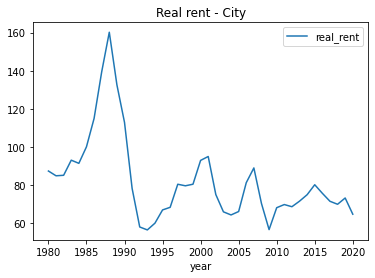

In [104]:
# Plot the series to understand how to best specify the ADF test (time trend or no time trend)
city_history.plot(x='year', y='real_rent', title = 'Real rent - City')

In [105]:
#city

In [106]:
# copied and modified the function for ADF test from the official documentation
# added the regression specification and the line on actual decision
# depending on the above plot, comment out or keep the line with "regression"

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC'
                      #, regression='ct'
                     )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    print ('We cannot reject (the null) that there is a unit root, the series are non-stationary' if dfoutput['p-value']>0.05 else 'The null (there is a unit root) is rejected, no unit root, the series is stationary')

In [107]:
# apply adf test function to the series of choice. The null is that there IS a unit root
# 0:41 is to specify hist values
adf_test(city_history['real_rent'])

Results of Dickey-Fuller Test:
Test Statistic                 -3.026106
p-value                         0.032527
#Lags Used                      1.000000
Number of Observations Used    39.000000
Critical Value (1%)            -3.610400
Critical Value (5%)            -2.939109
Critical Value (10%)           -2.608063
dtype: float64
The null (there is a unit root) is rejected, no unit root, the series is stationary


#### Long-run model

<AxesSubplot:label='de455650-1438-4f00-8aed-07748cd8c75f'>

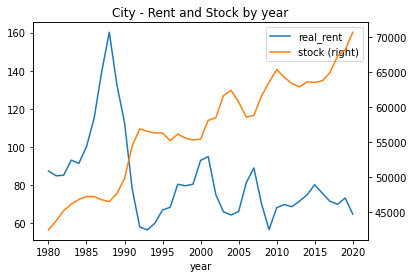

In [108]:
# Plot double axis plots to see the relationship between vars 
# this one is for City

rent_plot = city_history.plot(x='year', y='real_rent')
city_history.plot(x='year', y='stock',secondary_y=True, ax=rent_plot, title = 'City - Rent and Stock by year')

In [109]:
# Long run City

# Although Employment1 has the highest Adj R2, the residual is non-stationary
long_run_city = sm.OLS.from_formula(formula='ln_real_rent ~ ln_stock +ln_gdp',data = city_history).fit()
print(long_run_city.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_real_rent   R-squared:                       0.699
Model:                            OLS   Adj. R-squared:                  0.684
Method:                 Least Squares   F-statistic:                     44.21
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           1.21e-10
Time:                        18:00:03   Log-Likelihood:                 25.867
No. Observations:                  41   AIC:                            -45.73
Df Residuals:                      38   BIC:                            -40.59
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.7305      2.279     11.289      0.0

<AxesSubplot:title={'center':'City - Rent and Equilibrium (fitted) rent by year'}, xlabel='year'>

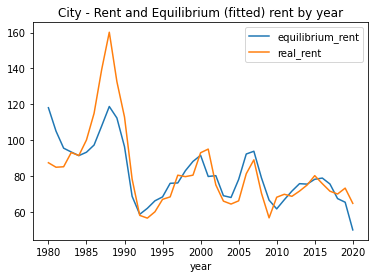

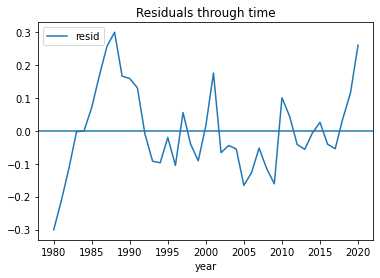

In [110]:
# get residuals, lagged residuals and fitted values and create plots

city_history['resid'] = long_run_city.resid
city_history['resid_lag'] = city_history['resid'].shift(1)

city_history['equilibrium_rent'] = np.exp(long_run_city.fittedvalues)

equil_rent = city_history.plot(x='year', y='equilibrium_rent')
city_history.plot(x='year', y='real_rent', ax=equil_rent, title = 'City - Rent and Equilibrium (fitted) rent by year')

resid_plot = city_history.plot(x='year', y='resid', title = 'Residuals through time')
resid_plot.axhline(y=0)

In [111]:
# test the stationarity of resid - City
# residuals are stationary - the trend is removed

adf_test(long_run_city.resid)

Results of Dickey-Fuller Test:
Test Statistic                 -2.867658
p-value                         0.049240
#Lags Used                      0.000000
Number of Observations Used    40.000000
Critical Value (1%)            -3.605565
Critical Value (5%)            -2.937069
Critical Value (10%)           -2.606986
dtype: float64
The null (there is a unit root) is rejected, no unit root, the series is stationary


#### Short-run model

In [112]:
# create the first differences
for i in ['ln_real_rent', 'ln_stock', 'ln_gdp']:
    city_history['diff_'+i] = city_history[i].diff()

In [113]:
# fitting the short-run model
# error term has an expected negative sign
# i.e. there is an adjustment towards a long-run equilibrium
short_run_city = sm.OLS.from_formula(formula='diff_ln_real_rent ~ diff_ln_stock + diff_ln_gdp+resid_lag',data = city_history).fit()
print(short_run_city.summary())

                            OLS Regression Results                            
Dep. Variable:      diff_ln_real_rent   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     17.97
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           2.69e-07
Time:                        18:00:03   Log-Likelihood:                 41.472
No. Observations:                  40   AIC:                            -74.94
Df Residuals:                      36   BIC:                            -68.19
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0097      0.022     -0.443

#### Creating the forecast

In [114]:
# Predict log of equilibrium rent, ln_real_rent_hat, outside of loop, as this value doesn't change
# because it only depends on logs of employment and stock
city['ln_real_rent_hat'] = long_run_city.predict(city[['ln_stock', 'ln_gdp']])
# let's also create equilibrium rent (the above , but not logged)
city['equilibrium_rent'] = np.exp(city['ln_real_rent_hat'])

# create the first differences of ln stock and ln employment, these also don't change
for k in ['ln_stock', 'ln_gdp']:
    city['diff_'+k] = city[k].diff()
    
# a loop to create ln_real_rent prediction
for i in range(41, 46):
    # Step 1: calculate error and create error lags
    city['resid'] = city['ln_real_rent'] - city['ln_real_rent_hat']
    city['resid_lag'] = city['resid'].shift(1)
    
    # Step 2: predict first differences in ln_real_rent by fitting the short-run model, now having one more error observation
    # resulting from previous step
    city['diff_ln_real_rent_hat'] = short_run_city.predict(city[['diff_ln_stock', 'diff_ln_gdp', 'resid_lag']])
    
    # Step 3: use the new first difference observation to calculate ln_real_rent using 
    # lag of ln_real_rent
    city["ln_real_rent"] = np.where(city.index == i, city['diff_ln_real_rent_hat'] + city['ln_real_rent'].shift(1), city['ln_real_rent'])  

In [115]:
# after the loop, de-log the rent
city['real_rent_forecast'] = np.exp(city['ln_real_rent'])
# nominalise the rent, using GDP-delator forecast
city['prime_rent_forecast'] = (city['real_rent_forecast'] * city['GDP deflator']) / 100

<AxesSubplot:title={'center':'Prime rent (nominal) - City'}, xlabel='year'>

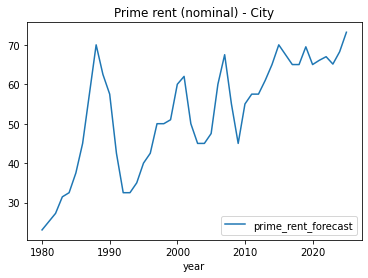

In [116]:
# plot the forecast
city.plot(x='year', y='prime_rent_forecast', title = 'Prime rent (nominal) - City')

In [117]:
city.loc[city["year"] > 2000,['year','real_rent', 'prime_rent_forecast','real_rent_forecast','equilibrium_rent', 'Employment2', 'gdp','stock', 'GDP deflator']]
#city[['year','real_rent', 'prime_rent_forecast','equilibrium_rent', 'Employment2', 'stock']]

,year,real_rent,prime_rent_forecast,real_rent_forecast,equilibrium_rent,Employment2,gdp,stock,GDP deflator
21,2001.0,95.017275,62.0,95.017275,79.733624,1764.8044,1621208.0,58105.558,65.251292
22,2002.0,75.048274,50.0,75.048274,80.193411,1695.9194,1656531.0,58467.250,66.623784
23,2003.0,65.982154,45.0,65.982154,69.002255,1694.4027,1711559.0,61631.941,68.200259
24,2004.0,64.348862,45.0,64.348862,68.015670,1673.2003,1750690.0,62380.478,69.931307
25,2005.0,66.141918,47.5,66.141918,78.077163,1723.6885,1802435.0,60714.634,71.815275
26,2006.0,81.260460,60.0,81.260460,92.266099,1781.4317,1850989.0,58574.300,73.836648
27,2007.0,89.017731,67.5,89.017731,93.815160,1851.6613,1894682.0,58801.881,75.82759
28,2008.0,70.351567,55.0,70.351567,78.935440,1905.3496,1889401.0,61571.374,78.178785
29,2009.0,56.652768,45.0,56.652768,66.541123,1836.5750,1811672.0,63533.445,79.431246
30,2010.0,68.148630,55.0,68.148630,61.646092,1896.7840,1849247.0,65351.240,80.705951


#### Output result

In [118]:
# select columns for outputting
city_select = city[['year','prime_rent_forecast','gdp','stock', 'GDP deflator']]

In [119]:
city_select  = pd.merge(city_select, citycore_primerent_kf, on='year', how = 'left') 

In [120]:
#city_select

In [121]:
#city_select.to_csv('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\forecast\\city_forecast.csv')

### West End

In [122]:
# create stock lags to check if they work
westend_history['ln_stock_lag'] = westend_history['ln_stock'].shift(1)
westend_history['ln_stock_2lag'] = westend_history['ln_stock'].shift(2)
westend_history['stock_lag'] = westend_history['stock'].shift(1)
westend_history['stock_2lag'] = westend_history['stock'].shift(2)

In [123]:
# correlation 
westend_history.corr()['real_rent']

year                      0.395746
availability             -0.479839
prime_rent                0.719824
stock                     0.095484
vacancy                  -0.331253
Employment1               0.475414
Employment2               0.474079
Employment3               0.483532
GVA1                      0.447324
GVA2                      0.442610
GVA3                      0.444489
Employment1_westmin       0.727769
Employment2_westmin       0.740302
Employment3_westmin       0.711578
GVA1_westmin              0.652890
GVA2_westmin              0.648324
GVA3_westmin              0.640020
gdp                       0.457987
cbr                      -0.190862
gva_constr                0.510926
vacancy_costar           -0.353974
stock_costar              0.178694
stock2                    0.095484
vacancy2                 -0.331253
real_rent                 1.000000
ln_stock                  0.100766
ln_stock2                 0.100766
ln_stock_costar           0.181921
ln_prime_rent       

#### Forecast availability

In [124]:
avail = sm.OLS.from_formula(formula='ln_availability ~ ln_gva_constr + ln_cbr',data = westend_history).fit()
print(avail.summary())

                            OLS Regression Results                            
Dep. Variable:        ln_availability   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.2391
Date:                Fri, 09 Jul 2021   Prob (F-statistic):              0.789
Time:                        18:00:04   Log-Likelihood:                -18.342
No. Observations:                  37   AIC:                             42.68
Df Residuals:                      34   BIC:                             47.52
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.3695      6.613      1.719

In [125]:
#westend_history['avail_fitted'] = np.exp(avail.fittedvalues)

westend['avail_fitted'] = np.exp(avail.predict(westend[['ln_gva_constr', 'ln_cbr']]))

In [126]:
westend.loc[westend["year"] > 2000,['year','availability', 'avail_fitted', 'ln_gva_constr', 'ln_cbr']]

,year,availability,avail_fitted,ln_gva_constr,ln_cbr
68,2001.0,4161.613,3405.105618,9.588270,1.634337
69,2002.0,4663.511,3482.368719,9.568169,1.386294
70,2003.0,5730.124,3454.642029,9.608183,1.306953
71,2004.0,5194.651,3398.435235,9.625076,1.477088
72,2005.0,3888.498,3460.810405,9.557781,1.536379
73,2006.0,2866.620,3406.192574,9.606872,1.534382
74,2007.0,2233.272,3280.228352,9.688579,1.706194
75,2008.0,4358.400,3243.527772,9.755075,1.542578
76,2009.0,4384.007,3823.716786,9.638890,-0.436198
77,2010.0,3924.110,3736.960125,9.759484,-0.693147


<AxesSubplot:label='5132b376-3503-436e-a420-e922052aaadb'>

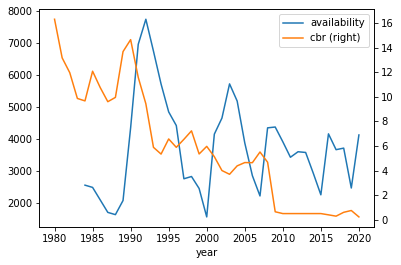

In [127]:
avail_plot = westend_history.plot(x='year', y='availability')
westend_history.plot(x='year', y='cbr',secondary_y=True, ax=avail_plot)

<AxesSubplot:label='aa462145-894d-44c7-a2eb-c36aa78be809'>

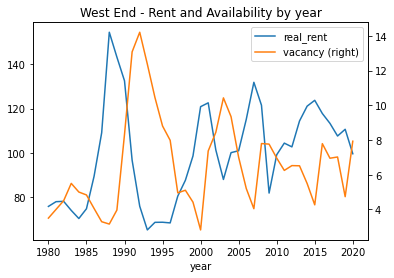

In [128]:
# Plot West End

rent_plot = westend_history.plot(x='year', y='real_rent')
westend_history.plot(x='year', y='vacancy',secondary_y=True, ax=rent_plot, title = 'West End - Rent and Availability by year')

#### Long-run model

In [129]:
# Long run West End

# when stock is used as a supply variable, the sign is positive.
long_run_westend = sm.OLS.from_formula(formula='ln_real_rent ~ ln_vacancy2 +ln_Employment3_westmin',data = westend_history).fit()
print(long_run_westend.summary())

                            OLS Regression Results                            
Dep. Variable:           ln_real_rent   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     23.96
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           1.04e-06
Time:                        18:00:05   Log-Likelihood:                 21.329
No. Observations:                  30   AIC:                            -36.66
Df Residuals:                      27   BIC:                            -32.46
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [130]:
#westend_history
html = westend_history.to_html()
path = os.path.abspath('westend_history.html')
url = 'file://' + path

with open(path, 'w') as f:
    f.write(html)
webbrowser.open(url)

56002

True

<AxesSubplot:title={'center':'West End - Rent and Equilibrium (fitted) rent by year'}, xlabel='year'>

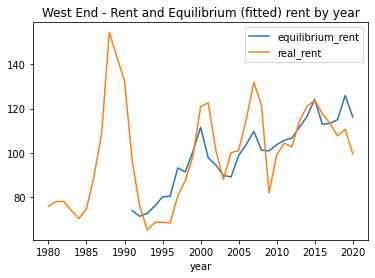

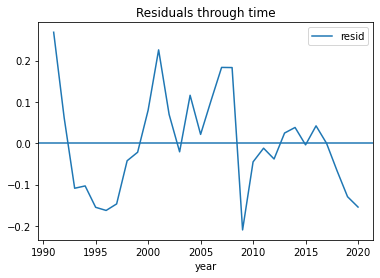

In [131]:
# get residuals, lagged residuals and fitted values and create plots
westend_history['resid'] = long_run_westend.resid
westend_history['resid_lag'] = westend_history['resid'].shift(1)

westend_history['equilibrium_rent'] = np.exp(long_run_westend.fittedvalues)

equil_rent = westend_history.plot(x='year', y='equilibrium_rent')
westend_history.plot(x='year', y='real_rent', ax=equil_rent, title = 'West End - Rent and Equilibrium (fitted) rent by year')

resid_plot = westend_history.plot(x='year', y='resid', title = 'Residuals through time')
resid_plot.axhline(y=0)

In [132]:
# Testing the stationarity of residuals - West End
# residual is stationary
adf_test(long_run_westend.resid)

Results of Dickey-Fuller Test:
Test Statistic                 -3.476173
p-value                         0.008621
#Lags Used                      0.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64
The null (there is a unit root) is rejected, no unit root, the series is stationary


#### Short-run model

In [133]:
# create the first differences
for i in ['ln_real_rent', 'ln_vacancy2', 'ln_Employment3_westmin']:
    westend_history['diff_'+i] = westend_history[i].diff()

In [134]:
# fitting the short-run model
# error term has an expected negative sign
# i.e. there is an adjustment towards a long-run equilibrium
short_run_westend = sm.OLS.from_formula(formula='diff_ln_real_rent ~ diff_ln_vacancy2 + diff_ln_Employment3_westmin + resid_lag',data = westend_history).fit()
print(short_run_westend.summary())

                            OLS Regression Results                            
Dep. Variable:      diff_ln_real_rent   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.467
Method:                 Least Squares   F-statistic:                     9.193
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           0.000283
Time:                        18:00:07   Log-Likelihood:                 27.962
No. Observations:                  29   AIC:                            -47.92
Df Residuals:                      25   BIC:                            -42.46
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

#### Creating the forecast

In [135]:
# Predict log of equilibrium rent, ln_real_rent_hat, outside of loop, as this value doesn't change
# because it only depends on logs of employment and stock
westend['ln_real_rent_hat'] = long_run_westend.predict(westend[['ln_vacancy2', 'ln_Employment3_westmin']])
# let's also create equilibrium rent (the above , but not logged)
westend['equilibrium_rent'] = np.exp(westend['ln_real_rent_hat'])

# create the first differences of ln stock and ln employment, these also don't change
for k in ['ln_vacancy2', 'ln_Employment3_westmin']:
    westend['diff_'+k] = westend[k].diff()
    
# a loop to create ln_real_rent prediction
for i in range(88, 93):
    # Step 1: calculate error and create error lags
    westend['resid'] = westend['ln_real_rent'] - westend['ln_real_rent_hat']
    westend['resid_lag'] = westend['resid'].shift(1)
    
    # Step 2: predict first differences in ln_real_rent by fitting the short-run model, now having one more error observation
    # resulting from previous step
    westend['diff_ln_real_rent_hat'] = short_run_westend.predict(westend[['diff_ln_vacancy2', 'diff_ln_Employment3_westmin', 'resid_lag']])
    
    # Step 3: use the new first difference observation to calculate ln_real_rent using 
    # lag of ln_real_rent
    westend["ln_real_rent"] = np.where(westend.index == i, westend['diff_ln_real_rent_hat'] + westend['ln_real_rent'].shift(1), westend['ln_real_rent']) 
    #westend[['year','diff_ln_real_rent_hat', 'ln_real_rent']]

In [136]:
# after the loop, de-log the rent
westend['real_rent_forecast'] = np.exp(westend['ln_real_rent'])
# nominalise the rent, using GDP-delator forecast
westend['prime_rent_forecast'] = (westend['real_rent_forecast'] * westend['GDP deflator']) / 100

<AxesSubplot:title={'center':'Prime rent (nominal) - West End'}, xlabel='year'>

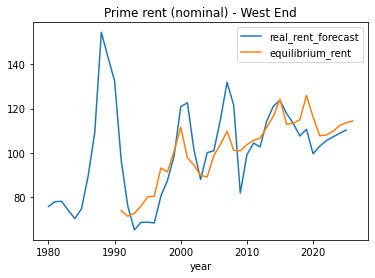

In [137]:
# plot the forecast
real_rent_forecast = westend.plot(x='year', y='real_rent_forecast')
westend.plot(x='year', y='equilibrium_rent', ax=real_rent_forecast, title = 'Prime rent (nominal) - West End')

In [138]:
westend[['year', 'prime_rent_forecast','real_rent_forecast', 'GDP deflator','equilibrium_rent', 'vacancy2', 'Employment3_westmin']]

,year,prime_rent_forecast,real_rent_forecast,GDP deflator,equilibrium_rent,vacancy2,Employment3_westmin
47,1980.0,20.0,75.802596,26.384321,NaN,3.500000,NaN
48,1981.0,23.1,77.943476,29.636862,NaN,4.000000,NaN
49,1982.0,25.0,78.100904,32.009873,NaN,4.500000,NaN
50,1983.0,25.0,73.998816,33.784324,NaN,5.500000,NaN
51,1984.0,25.0,70.328223,35.547607,NaN,5.001392,NaN
52,1985.0,28.0,74.743130,37.461637,NaN,4.833937,NaN
53,1986.0,35.0,89.418598,39.141745,NaN,4.054778,NaN
54,1987.0,45.0,109.096346,41.247944,NaN,3.292362,NaN
55,1988.0,67.5,154.496355,43.690351,NaN,3.156668,NaN
56,1989.0,67.5,143.257126,47.118075,NaN,3.964483,NaN


In [139]:
#westend.to_csv('G:\\29 Data Analytics\\Commercial research projects\\MS\\CL office rents\\westend.csv')

#### Output results

In [140]:
westend_select = westend[['year','prime_rent_forecast','Employment3_westmin','vacancy2', 'GDP deflator']]

In [141]:
westend_select  = pd.merge(westend_select, westend_primerent_kf, on='year', how = 'left') 

In [144]:
#westend_select

,year,prime_rent_forecast,Employment3_westmin,vacancy2,GDP deflator,kf_prime_rent
0,1980.0,20.0,NaN,3.500000,26.384321,NaN
1,1981.0,23.1,NaN,4.000000,29.636862,NaN
2,1982.0,25.0,NaN,4.500000,32.009873,NaN
3,1983.0,25.0,NaN,5.500000,33.784324,NaN
4,1984.0,25.0,NaN,5.001392,35.547607,NaN
5,1985.0,28.0,NaN,4.833937,37.461637,NaN
6,1986.0,35.0,NaN,4.054778,39.141745,NaN
7,1987.0,45.0,NaN,3.292362,41.247944,NaN
8,1988.0,67.5,NaN,3.156668,43.690351,NaN
9,1989.0,67.5,NaN,3.964483,47.118075,65.0


In [143]:
#westend_select.to_csv('F:\\Research\\CommercialPrivate\\Central London\\DATA\\FORECASTS\\2021\\Q2 2021\\forecast\\westend_forecast.csv')